In [1]:
import pyomo.environ as pyo

# problem 1 description:

    o find the best location for warehouses minimizing the transportation costs.
    
    o Let N be a set of candidate warehouse locations, and let M be a set of customer locations.
    
    o For each warehouse n, the cost of delivering product to customer m is given by d_n,m.
    
    o The binary variables y_n are used to define whether or not a warehouse should be built, where y_n is 1 if warehouse n       is selected and 0 otherwise.
    
    o The variable x_n,m indicates the fraction of demand for customer m that is served by warehouse n.

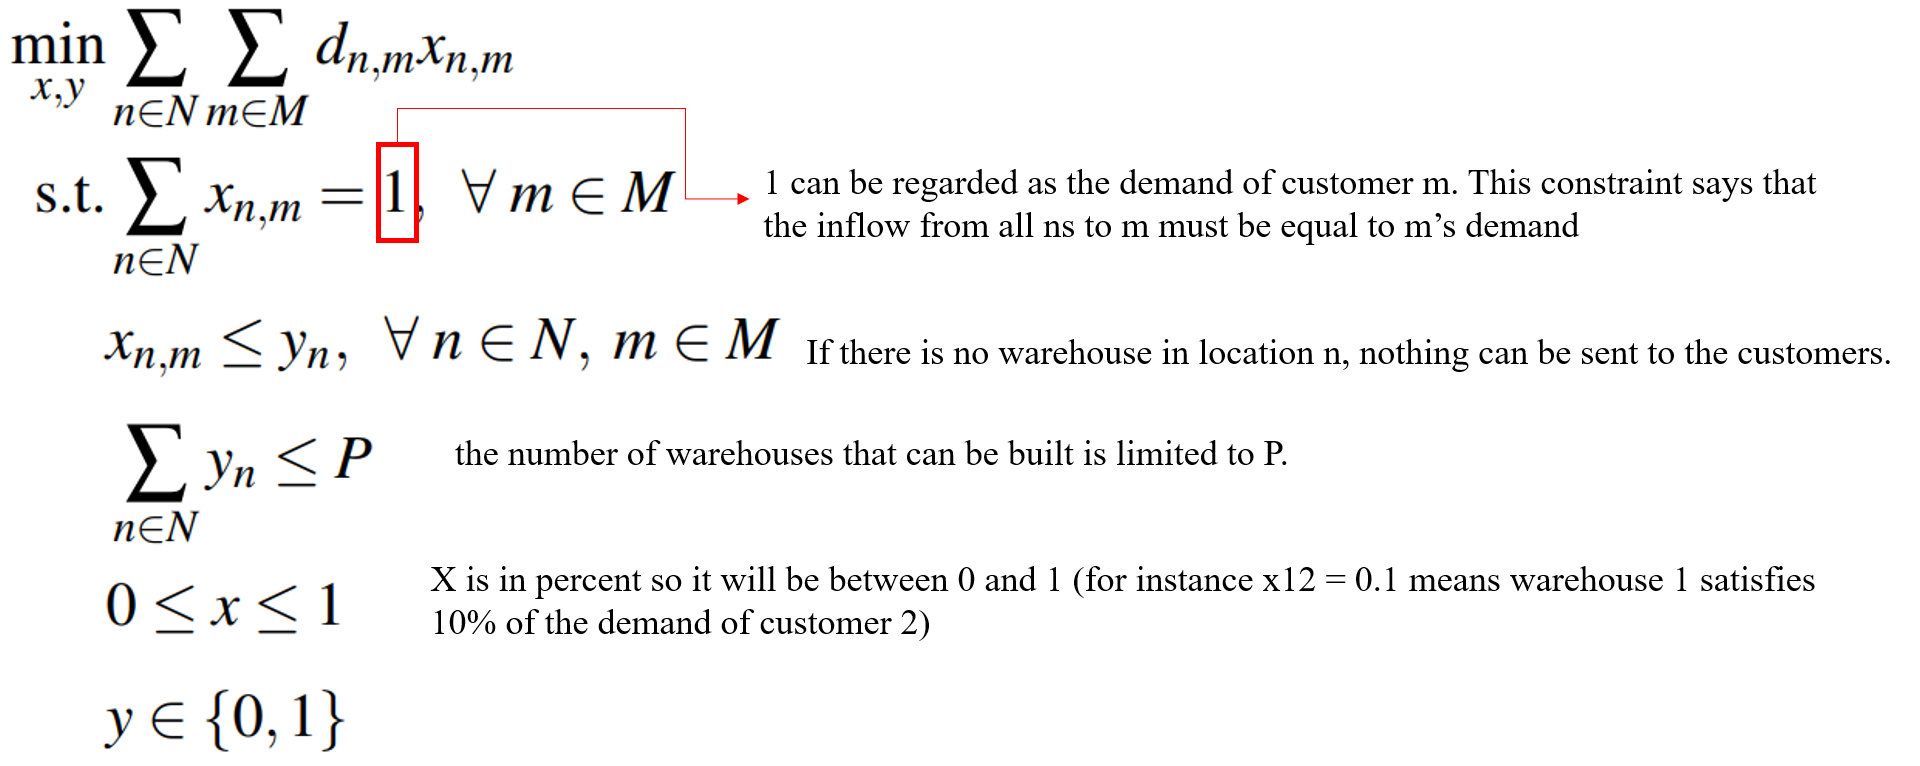

## create an instance of the model

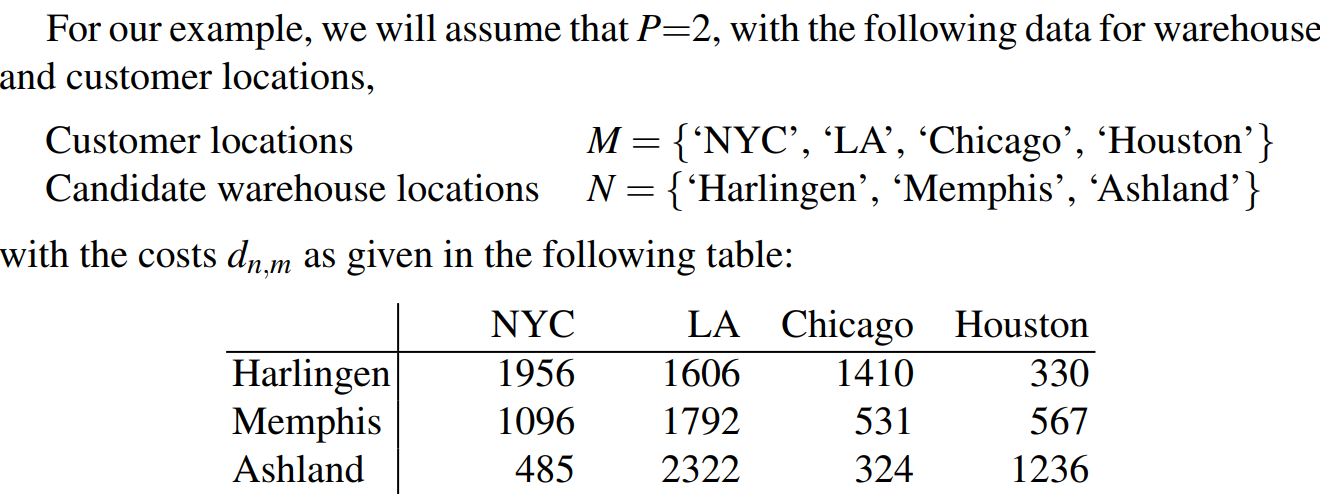

## define the concrete model

In [2]:
def create_warehouse_model(N, M, d, P):
    """
        N: set of candidate warehouse locations
        M: set of customer locations
        d: delivery cost
        P: maximum number of warehouses
    """
    
    model = pyo.ConcreteModel(name="(WL)")
    
    model.x = pyo.Var(N, M, bounds=(0,1))   #percentage of good one wants to send from n to m
    model.y = pyo.Var(N, within=pyo.Binary) # whther warehouse n exists

    def obj_rule(model):
        return sum(d[n,m]*model.x[n,m] for n in N for m in M)
    model.obj = pyo.Objective(rule=obj_rule) # by default the sense is minimization

    def demand_rule(model, m): # for all ms, sum over all ns
        return sum(model.x[n,m] for n in N) == 1
    model.demand = pyo.Constraint(M, rule=demand_rule) # for all ms

    def warehouse_active_rule(model, n, m): # for all ms and ns
        return model.x[n,m] <= model.y[n]
    model.warehouse_active = pyo.Constraint(N, M, rule=warehouse_active_rule)

    def num_warehouses_rule(model):
        return sum(model.y[n] for n in N) <= P
    model.num_warehouses = pyo.Constraint(rule=num_warehouses_rule)
    
    return model

## define specific data to solve the model

In [3]:
N = ["Harlingen", "Memphis", "Ashland"]
M = ["NYC", "LA", "Chicago", "Houston"]

d = {
("Harlingen", "NYC"): 1956,
("Harlingen", "LA"): 1606,
("Harlingen", "Chicago"): 1410,
("Harlingen", "Houston"): 330,
("Memphis", "NYC"): 1096,
("Memphis", "LA"): 1792,
("Memphis", "Chicago"): 531,
("Memphis", "Houston"): 567,
("Ashland", "NYC"): 485,
("Ashland", "LA"): 2322,
("Ashland", "Chicago"): 324,
("Ashland", "Houston"): 1236 }

P = 2

model = create_warehouse_model(N, M, d, P)

In [4]:
solver = pyo.SolverFactory("glpk")
res = solver.solve(model)

print(pyo.check_optimal_termination(res))

True


In [5]:
model.y.pprint()

y : Size=3, Index=y_index
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :   0.0 :     1 : False : False : Binary


In [8]:
print(model.obj.expr)                    # see the OF expression

1956*x[Harlingen,NYC] + 1606*x[Harlingen,LA] + 1410*x[Harlingen,Chicago] + 330*x[Harlingen,Houston] + 1096*x[Memphis,NYC] + 1792*x[Memphis,LA] + 531*x[Memphis,Chicago] + 567*x[Memphis,Houston] + 485*x[Ashland,NYC] + 2322*x[Ashland,LA] + 324*x[Ashland,Chicago] + 1236*x[Ashland,Houston]


In [9]:
print(pyo.value(model.obj))              # see the value of the OF at the optimal point

2745.0


In [15]:
print(pyo.value(model.y["Harlingen"]))   # access the vlaue of a specific variable

1.0


In [18]:
print([pyo.value(model.y[loc]) for loc in model.y])

[1.0, 0.0, 1.0]


In [21]:
for v in model.component_objects(ctype=pyo.Var):
    print(v)
    for index in v:
        print("{0} <= {1} <= {2}".format(pyo.value(v[index].lb), v[index], pyo.value(v[index].ub)))

x
0 <= x[Harlingen,NYC] <= 1
0 <= x[Harlingen,LA] <= 1
0 <= x[Harlingen,Chicago] <= 1
0 <= x[Harlingen,Houston] <= 1
0 <= x[Memphis,NYC] <= 1
0 <= x[Memphis,LA] <= 1
0 <= x[Memphis,Chicago] <= 1
0 <= x[Memphis,Houston] <= 1
0 <= x[Ashland,NYC] <= 1
0 <= x[Ashland,LA] <= 1
0 <= x[Ashland,Chicago] <= 1
0 <= x[Ashland,Houston] <= 1
y
0 <= y[Harlingen] <= 1
0 <= y[Memphis] <= 1
0 <= y[Ashland] <= 1


# problem 2 description:

In [22]:
#     min z = y - x
#     y + x = 1
#     0 <= x <= 5
#     0 <= y <= 1

model = pyo.ConcreteModel()
model.x = pyo.Var(bounds=(0,5))
model.y = pyo.Var(bounds=(0,1))
model.con = pyo.Constraint(expr=model.x + model.y == 1.0)
model.obj = pyo.Objective(expr=model.y-model.x)
# solve the problem
solver = pyo.SolverFactory("glpk")
solver.solve(model)
print(pyo.value(model.x))
print(pyo.value(model.y))

1.0
0.0


### add a constraint

In [23]:
model.con2 = pyo.Constraint(expr=4.0*model.x + model.y == 2.0)
solver.solve(model)
print(pyo.value(model.x))
print(pyo.value(model.y))

0.333333333333333
0.666666666666667


### deactive a constraint

In [24]:
model.con.deactivate()
solver.solve(model)
print(pyo.value(model.x))
print(pyo.value(model.y))

0.5
0.0


### reactive a constraint

In [25]:
model.con.activate()
solver.solve(model)
print(pyo.value(model.x)) 
print(pyo.value(model.y)) 

0.333333333333333
0.666666666666667


### delete a constraint

In [26]:
del model.con2
solver.solve(model)
print(pyo.value(model.x)) 
print(pyo.value(model.y)) 

1.0
0.0


### fix a variable

In [27]:
model.x.fix(0.5)
solver.solve(model)
print(pyo.value(model.x))
print(pyo.value(model.y))

0.5
0.5


In [ ]:
### unfix a variable

In [28]:
model.x.unfix()
solver.solve(model)
print(pyo.value(model.x))
print(pyo.value(model.y))

1.0
0.0


# solve soduko table with LP

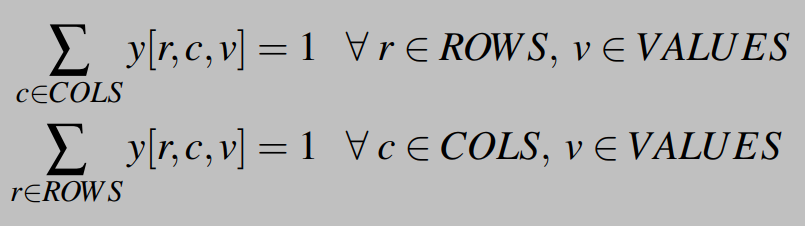

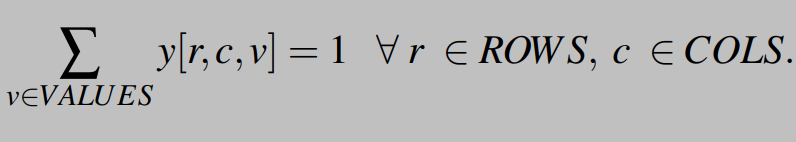

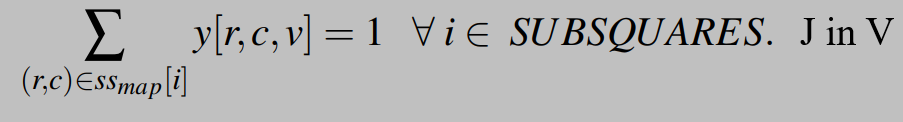

In [29]:
# create a standard python dict for mapping subsquares to
# the list (row,col) entries
subsq_to_row_col = dict()
subsq_to_row_col[1] = [(i,j) for i in range(1,4) for j in range(1,4)]
subsq_to_row_col[2] = [(i,j) for i in range(1,4) for j in range(4,7)]
subsq_to_row_col[3] = [(i,j) for i in range(1,4) for j in range(7,10)]
subsq_to_row_col[4] = [(i,j) for i in range(4,7) for j in range(1,4)]
subsq_to_row_col[5] = [(i,j) for i in range(4,7) for j in range(4,7)]
subsq_to_row_col[6] = [(i,j) for i in range(4,7) for j in range(7,10)]
subsq_to_row_col[7] = [(i,j) for i in range(7,10) for j in range(1,4)]
subsq_to_row_col[8] = [(i,j) for i in range(7,10) for j in range(4,7)]
subsq_to_row_col[9] = [(i,j) for i in range(7,10) for j in range(7,10)]

In [30]:
# creates the sudoku model for a 10x10 board, where the
# input board is a list of fixed numbers specified in
# (row, col, val) tuples.
def create_sudoku_model(board):
    
    model = pyo.ConcreteModel()
    
    # store the starting board for the model
    model.board = board
    
    # create sets for rows columns and squares
    model.ROWS = pyo.RangeSet(1,9)
    model.COLS = pyo.RangeSet(1,9)
    model.SUBSQUARES = pyo.RangeSet(1,9)
    model.VALUES = pyo.RangeSet(1,9)
    
    # create the binary variables to define the values
    model.y = pyo.Var(model.ROWS, model.COLS, model.VALUES, within=pyo.Binary)
    
    # fix variables based on the current board
    for (r,c,v) in board:
        model.y[r,c,v].fix(1)
    
    # create the objective - this is a feasibility problem
    # so we just make it a constant
    model.obj = pyo.Objective(expr= 1.0)
    
    # exactly one number in each row
    def _RowCon(model, r, v):
        return sum(model.y[r,c,v] for c in model.COLS) == 1
    model.RowCon = pyo.Constraint(model.ROWS, model.VALUES, rule=_RowCon)
    
    # exactly one number in each column
    def _ColCon(model, c, v):
        return sum(model.y[r,c,v] for r in model.ROWS) == 1
    model.ColCon = pyo.Constraint(model.COLS, model.VALUES, rule=_ColCon)
    
    # exactly one number in each subsquare
    def _SqCon(model, s, v):
        return sum(model.y[r,c,v] for (r,c) in subsq_to_row_col[s]) == 1
    model.SqCon = pyo.Constraint(model.SUBSQUARES, model.VALUES, rule=_SqCon)
    
    # exactly one number in each cell
    def _ValueCon(model, r, c):
        return sum(model.y[r,c,v] for v in model.VALUES) == 1
    model.ValueCon = pyo.Constraint(model.ROWS, model.COLS, rule=_ValueCon)
    
    return model

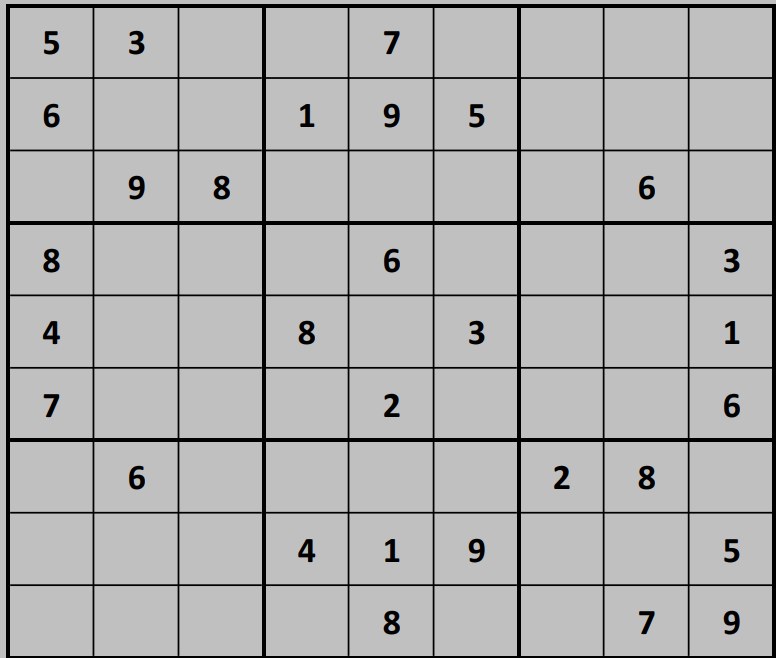

In [32]:
board = [(1,1,5),(1,2,3),(1,5,7),(2,1,6),(2,4,1),(2,5,9),(2,6,5),(3,2,9),(3,3,8),(3,8,6),(4,1,8),(4,5,6),(4,9,3),
(5,1,4),(5,4,8),(5,6,3),(5,9,1),(6,1,7),(6,5,2),(6,9,6),(7,2,6),(7,7,2),(7,8,8),(8,4,4),(8,5,1),(8,6,9),(8,9,5),
(9,5,8),(9,8,7),(9,9,9)]

In [33]:
model = create_sudoku_model(board)

solver = pyo.SolverFactory("glpk")
res = solver.solve(model)

print(pyo.check_optimal_termination(res))

    solver failure.
True


In [36]:
def print_solution(model):
    for r in model.ROWS:
        print(" ".join(str(v) for c in model.COLS
        for v in model.VALUES
            if pyo.value(model.y[r,c,v]) >= 0.5))

In [37]:
print_solution(model)

5 3 4 6 7 8 9 1 2
6 7 2 1 9 5 3 4 8
1 9 8 3 4 2 5 6 7
8 5 9 7 6 1 4 2 3
4 2 6 8 5 3 7 9 1
7 1 3 9 2 4 8 5 6
9 6 1 5 3 7 2 8 4
2 8 7 4 1 9 6 3 5
3 4 5 2 8 6 1 7 9
